In [60]:
# Using VIX index as a predictor of Russell 2000 prices to test using percentage change of expectation of volatility index against the percent change of the price of a stock index.

In [61]:
## Data Preparation
# 1. Rolling 10 day window (ten trading days)
# 2. 70% training data 30% testing data
# 3. Use MinMaxScaler to X and y values

In [62]:
# Imports

import yfinance as yf
import numpy as np
import pandas as pd
import hvplot.pandas

In [63]:
# Setting random seed for testing - will comment out for final product

#from numpy.random import seed
#seed(1)
#from tensorflow import random
#random.set_seed(2)

In [64]:
# Load price data for VIX using yfinance

index_df = yf.download("^VIX", start='2019-01-01', end='2021-05-31')
index_df = index_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'^VIX'})
index_df = index_df['^VIX'].pct_change()
index_df = index_df.dropna()
index_df.head()

[*********************100%***********************]  1 of 1 completed


Date
2019-01-03    0.096038
2019-01-04   -0.159921
2019-01-07    0.000935
2019-01-08   -0.043458
2019-01-09   -0.023937
Name: ^VIX, dtype: float64

In [65]:
# Load price data for RUT using yfinance
stock_df = yf.download("^RUT", start='2019-01-01', end='2021-05-31')
stock_df = stock_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'^RUT'})
stock_df = stock_df['^RUT'].pct_change()
stock_df = stock_df.dropna()
stock_df.head()

[*********************100%***********************]  1 of 1 completed


Date
2019-01-03   -0.018497
2019-01-04    0.037510
2019-01-07    0.017831
2019-01-08    0.015071
2019-01-09    0.008594
Name: ^RUT, dtype: float64

In [66]:
# Concatenate into single df

df = pd.concat([index_df, stock_df], axis="columns", join="inner")
df

,^VIX,^RUT
Date,,
2019-01-03,0.096038,-0.018497
2019-01-04,-0.159921,0.037510
2019-01-07,0.000935,0.017831
2019-01-08,-0.043458,0.015071
2019-01-09,-0.023937,0.008594
2019-01-10,-0.024024,0.004601
2019-01-11,-0.067179,0.001349
2019-01-14,0.048378,-0.010066
2019-01-15,-0.024646,0.008661


In [67]:
# Below function takes column number for the features (X) and target (y)
# It accumulates the data with a rolling window of X(t-n) to predict Xt
# Finally, it returns a numpy array of X and y

def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    print(len(df) - window - 1)
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [68]:
# Predict Closing Prices using a 10 day window of previous closing prices

window_size = 10

# Column index 0 is the 'index' column
# Column index 1 is the 'stock' column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

595


In [69]:
# 70% of data will be for training and 30% for testing

from sklearn.model_selection import train_test_split
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [70]:
# Scaling data between 0 and 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [71]:
# Reshape the features for the model

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [72]:
## Building/training LSTM RNN

In [73]:
# Imports from tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [74]:
# LSTM Model
# How many layers are we doing? Check before doing return sequences. Set to True if adding more LSTM layers but not for final layer
# Input shape: number of time steps and number of indicators
# Dropouts to prevent overfitting
# Define the LSTM RNN model
# Using 10 units per layer to match the window size of 10
# Randomly dropping 20% of neurons per epoch

model = Sequential()

number_units = 10
dropout_fraction = 0.2

# Layer 1

model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2

model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3

model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer

model.add(Dense(1))

In [75]:
# Compile the model
# What is Adam?

model.compile(optimizer="adam", loss="mean_squared_error")

In [76]:
# Summarize the model

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 10)            840       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [77]:
# Train the model

model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=1, verbose=1)

Epoch 1/50
416/416 [==============================] - 15s 13ms/step - loss: 0.0878
Epoch 2/50
416/416 [==============================] - 6s 13ms/step - loss: 0.0132
Epoch 3/50
416/416 [==============================] - 5s 13ms/step - loss: 0.0111
Epoch 4/50
416/416 [==============================] - 7s 16ms/step - loss: 0.0102
Epoch 5/50
416/416 [==============================] - 7s 17ms/step - loss: 0.0089
Epoch 6/50
416/416 [==============================] - 7s 18ms/step - loss: 0.0084
Epoch 7/50
416/416 [==============================] - 7s 17ms/step - loss: 0.0070
Epoch 8/50
416/416 [==============================] - 6s 15ms/step - loss: 0.0057
Epoch 9/50
416/416 [==============================] - 7s 16ms/step - loss: 0.0059
Epoch 10/50
416/416 [==============================] - 7s 17ms/step - loss: 0.0052
Epoch 11/50
416/416 [==============================] - 7s 16ms/step - loss: 0.0055
Epoch 12/50
416/416 [==============================] - 7s 17ms/step - loss: 0.0045
Epoch 13/50


In [78]:
## Model Performance

In [79]:
# Evaluate the model

model.evaluate(X_test, y_test)

6/6 [==============================] - 3s 7ms/step - loss: 0.0041


0.004115000832825899

In [80]:
# Predictions

predicted = model.predict(X_test)

In [81]:
# Recover the unscaled prices

predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [82]:
# Create df of predicted and real prices

stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-09-14,-0.006951,0.001552
2020-09-15,0.026515,0.001647
2020-09-16,0.000768,0.001727
2020-09-17,0.009219,0.001774
2020-09-18,-0.006268,0.001773


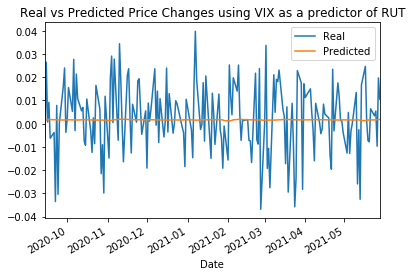

In [92]:
# Real vs predicted line plot to check fit

stocks.plot(title="Real vs Predicted Price Changes using VIX as a predictor of RUT")

In [84]:
#Importing for correlation

index_df = yf.download("^VIX", start='2019-01-01', end='2021-05-31')
index_df = index_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'VIX^'})
index_df.head()

[*********************100%***********************]  1 of 1 completed


,VIX^
Date,
2019-01-02,23.219999
2019-01-03,25.450001
2019-01-04,21.379999
2019-01-07,21.400000
2019-01-08,20.469999


In [85]:
stock_df = yf.download("^RUT", start='2019-01-01', end='2021-05-31')
stock_df = stock_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'^RUT'})
stock_df.head()

[*********************100%***********************]  1 of 1 completed


,^RUT
Date,
2019-01-02,1355.910034
2019-01-03,1330.829956
2019-01-04,1380.750000
2019-01-07,1405.369995
2019-01-08,1426.550049


In [86]:
df = pd.concat([index_df, stock_df], axis="columns", join="inner")
df

,VIX^,^RUT
Date,,
2019-01-02,23.219999,1355.910034
2019-01-03,25.450001,1330.829956
2019-01-04,21.379999,1380.750000
2019-01-07,21.400000,1405.369995
2019-01-08,20.469999,1426.550049
2019-01-09,19.980000,1438.810059
2019-01-10,19.500000,1445.430054
2019-01-11,18.190001,1447.380005
2019-01-14,19.070000,1432.810059


In [87]:
# Correlation graphs

correlation = df.corr()
correlation

,VIX^,^RUT
VIX^,1.000000,-0.354674
^RUT,-0.354674,1.000000


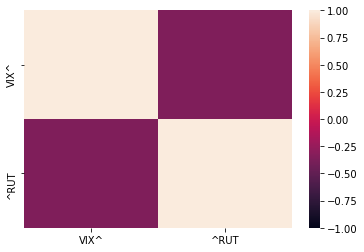

In [90]:
import seaborn as sns
sns.heatmap(correlation, vmin=-1, vmax=1)

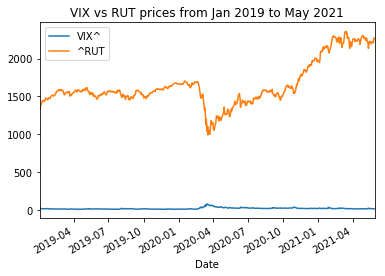

In [89]:
# Additional visuals

df.plot(title="VIX vs RUT prices from Jan 2019 to May 2021")